## Importing Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

# Visualization
import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Reading the data

In [2]:
# Get the data
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"

files = glob.glob( folder + "Ex *.xlsx" ) 

minutes = []
temp = []

k = 0
for file in files:
    k = k +1
    if k > 2:
        break
    df = pd.read_excel(file) # reading the excel file
    
    file_min = df.iloc[:,0] #getting only the minutes
    file_temp = df.iloc[:,3::2] # slicing the data for only temperature
    
    minutes.append(file_min) # adding minutes into the list
    temp.append(file_temp) # adding the file into the list
  

## Scores for each dataset

<ipython-input-14-516a5616744c>:103: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-14-516a5616744c>:103: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-14-516a5616744c>:103: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-14-516a5616744c>:103: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-14-516a5616744c>:103: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-14-516a5616744c>:103: UserWarning: Matpl

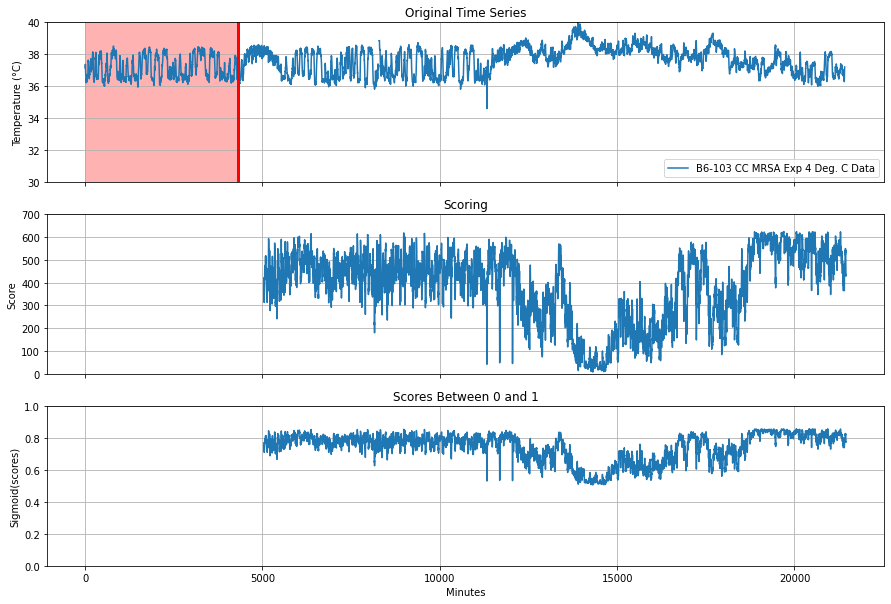

In [14]:
fig,ax = plt.subplots(3,1,figsize=(15,10), sharex = True)
fig.set_facecolor("white") # Changing the border to white

model = svm.OneClassSVM() # importing the model

# Sigmoid Definition
beta = (2/700)
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

# Plotting each file's temperature vs. minutes
for i in range(len(minutes)):
    mouse_min = minutes[i] # renaming the minutes to the current column
    mouse_temp = temp[i] # renaming the temperature to the current column
    #x_axis = mouse_min # defining the x axis
    
    # A for loop for the temperatures (extracting only the column of data frame)
    for j in range(mouse_temp.shape[1]): 
        ax[0].clear() # clear axis for each individual mouse
        ax[1].clear() # clear axis
        ax[2].clear()
        """
        ax[3].clear()
        ax[4].clear()
        ax[5].clear()
        """
        y_axis = mouse_temp.iloc[:,j] # defining the y axis
        names = mouse_temp.columns[j] # extracting the names of the columns (mouse name)
        
        # Filling in missing values using forward fill
        y1_fw = y_axis.fillna(method='ffill')
        y1_bw = y1_fw.fillna(method='bfill') #backward fill
        
        # Extracting column names
        #names = mouse_temp.columns[j] #doubled
        
        # Time Delay Embedding
        Y = tde.tde(y1_bw) #using the tde file
        Y = Y.T #transporting the data
        
        # Fit the Data
        model.fit(Y[:4321,:]) #training the data for the first 3 days (3*24*60)
                                ###starts on 720 b/c of the tde
                                ###need to change the ending value for Y
        # Predict the Data
        predict = model.predict(Y[4321:,:]) #predicting on the rest of the days
        scores = model.score_samples(Y[4321:,:]) #scoring on the rest of the days 
        
        # Predict on the training data
        predict_training = model.predict(Y[:4321,:])
        scores_training = model.score_samples(Y[:4321,:])
        sig_training = sigmoid(beta, scores_training)
        
        # Plotting the Scatterplot
        ax[0].plot(mouse_min, y_axis, label=names)
        ax[0].grid()
        ax[0].set_title("Original Time Series") # setting a title
        ax[0].set_ylabel('Temperature (°C)') # y label
        ax[0].legend() # name of the mouse
        ax[0].set_ylim(30,40) # y limits
        ax[0].axvline(4321, c='r', lw=3)
        ax[0].axvspan(0,4321, color='r', alpha=0.3)
        
        # Plotting the Scores
        ax[1].plot(mouse_min[5041:], scores)
        ax[1].grid()
        ax[1].set_title("Scoring") # setting a title
        ax[1].set_ylabel("Score") # y label
        #ax[1].legend() # name of the mouse
        ax[1].set_ylim(0,700) # y limits
        
        # Values between 0 and 1 using sigmoid
        sig = sigmoid(beta, scores)
        ax[2].plot(mouse_min[5041:], sig)
        ax[2].grid()
        ax[2].set_xlabel('Minutes')
        ax[2].set_ylabel('Sigmoid(scores)')
        ax[2].set_title('Scores Between 0 and 1')
        ax[2].set_ylim(0,1)
        '''
        ax[3].plot(mouse_min, predict_training, label=names)
        ax[3].grid()
        ax[3].set_title("Original Time Series") # setting a title
        ax[3].set_ylabel('Temperature (°C)') # y label
        ax[3].legend() # name of the mouse
        ax[3].set_ylim(30,40) # y limits
        
        ax[4].plot(mouse_min[:5041], scores_training)
        ax[4].grid()
        ax[4].set_title("Scoring") # setting a title
        ax[4].set_ylabel("Score") # y label
        #ax[4].legend() # name of the mouse
        ax[4].set_ylim(0,700) # y limits
        
        ax[5].plot(mouse_min[:5041], sig_training)
        ax[5].grid()
        ax[5].set_xlabel('Minutes')
        ax[5].set_ylabel('Sigmoid(scores)')
        ax[5].set_title('Scores Between 0 and 1')
        ax[5].set_ylim(0,1)
        '''
        #fig.tight_layout()
        fig.show()
        
        #SAVING EACH PLOT
        #filename = "Scores/%s.png"%names # saving the file as the name of the mouse
        #fig.savefig(filename)
        #print("Prediction for " + names, "is: \n", predict, "\n with score \n ", +  scores)

ValueError: x and y must have same first dimension, but have shapes (20192,) and (4321,)

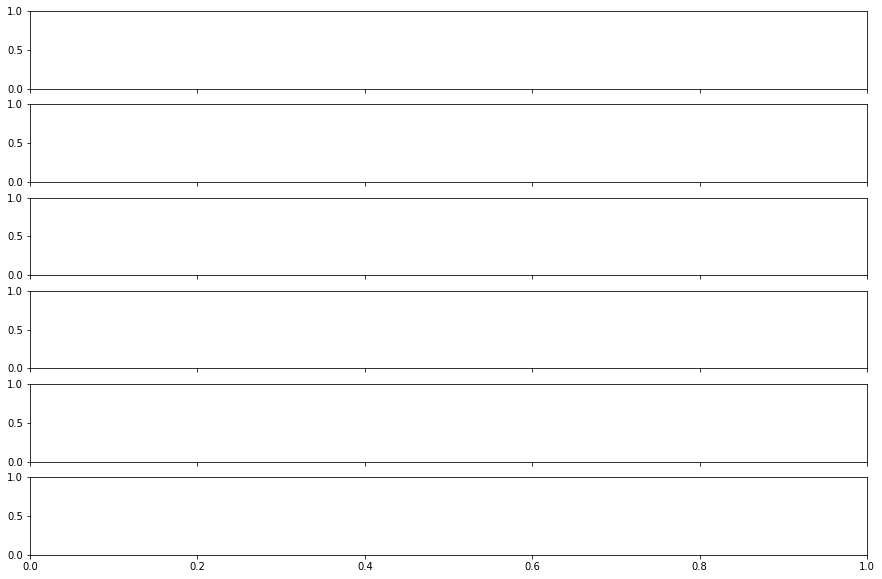

In [10]:
fig, ax = plt.subplots(6, 1, figsize=(15, 10), sharex=True)
fig.set_facecolor("white")  # Changing the border to white

model = svm.OneClassSVM()  # importing the model

# Sigmoid Definition
beta = (2 / 700)
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

# Plotting each file's temperature vs. minutes
for i in range(len(minutes)):
    mouse_min = minutes[i]  # renaming the minutes to the current column
    mouse_temp = temp[i]  # renaming the temperature to the current column

    for j in range(mouse_temp.shape[1]):
        ax[0].clear()  # clear axis for each individual mouse
        ax[1].clear()  # clear axis
        ax[2].clear()

        y_axis = mouse_temp.iloc[:, j]  # defining the y axis
        names = mouse_temp.columns[j]  # extracting the names of the columns (mouse name)

        # Filling in missing values using forward fill
        y1_fw = y_axis.fillna(method='ffill')
        y1_bw = y1_fw.fillna(method='bfill')  # backward fill

        # Time Delay Embedding
        Y = tde.tde(y1_bw)  # using the tde file
        Y = Y.T  # transporting the data

        # Fit the Data
        model.fit(Y[:4321, :])  # training the data for the first 3 days (3*24*60)
        
        
        
        # Predict on the training data
        predict_training = model.predict(Y[:4321,:])
        scores_training = model.score_samples(Y[:4321,:])
        sig_training = sigmoid(beta, scores_training)

        if j == 0:  # Only plot the first subplot
            ax[0].plot(mouse_min, predict_training, label=names)
            ax[0].grid()
            ax[0].set_title("Original Time Series")  # setting a title
            ax[0].set_ylabel('Temperature (°C)')  # y label
            ax[0].legend() # name of the mouse
            ax[0].set_ylim(30,40) # y limits
        
            ax[1].plot(mouse_min[:5041], scores_training)
            ax[1].grid()
            ax[1].set_title("Scoring") # setting a title
            ax[1].set_ylabel("Score") # y label
            #ax[1].legend() # name of the mouse
            ax[1].set_ylim(0,700) # y limits
        
            ax[2].plot(mouse_min[:5041], sig_training)
            ax[2].grid()
            ax[2].set_xlabel('Minutes')
            ax[2].set_ylabel('Sigmoid(scores)')
            ax[2].set_title('Scores Between 0 and 1')
            ax[2].set_ylim(0,1)
            #fig.tight_layout()
            fig.show()

## Adding vertical line

In [ ]:
# Read temperature data
temperature_data = pd.read_csv('temperature_file.csv')

# Read infection time data
infection_data = pd.read_csv('infection_file.csv', index_col=0)

# Extract time series from temperature data
time_series = temperature_data.iloc[:, 1:]  # Assuming the time series is in columns after the first column

# Convert the time series data to the desired format (e.g., numeric)
time_series = time_series.apply(pd.to_numeric, errors='coerce')

# Create a list of infection times
infection_times = infection_data.columns.tolist()

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series)

# Add vertical lines for infection times
for infection_time in infection_times:
    plt.axvline(x=infection_time, color='red', linestyle='--')

# Customize the plot as needed (e.g., add labels, titles, etc.)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Time Series with Infection Times')

# Show the plot
plt.show()

## Adding vetical line for each corresponding time series

In [ ]:
# Read temperature data
temperature_data = pd.read_csv('/Users/yoddmena/Downloads/Research/Telemetry_edited/Ex 01 - 05_06_19 - Edited.xlsx')

# Read infection time data
infection_data = pd.read_csv('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# Extract time series from temperature data
time_series = temperature_data.iloc[:, 1:]  # Assuming the time series is in columns after the first column

# Convert the time series data to the desired format (e.g., numeric)
time_series = time_series.apply(pd.to_numeric, errors='coerce')

# Create a list of infection times
infection_times = infection_data.columns.tolist()

# Plot each time series with corresponding infection time
for mouse_name in time_series.columns:
    # Get the time series and infection time for the current mouse
    mouse_time_series = time_series[mouse_name]
    mouse_infection_time = infection_times[mouse_name]

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(mouse_time_series)

    # Add vertical line for infection time
    plt.axvline(x=mouse_infection_time, color='red', linestyle='--')

    # Customize the plot as needed (e.g., add labels, titles, etc.)
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title(f'Temperature Time Series for {mouse_name} with Infection Time')

    # Show the plot or save it to a file
    plt.show()  # or plt.savefig(f'time_series_{mouse_name}.png')